### Imports

In [645]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from typing import List

from ipywidgets import interact
import ipywidgets as widgets
from scipy.integrate import simpson

### Constantes

In [646]:
YEARS = 10
PI = np.pi
DELTA = 1/365

### Funciones utiles

In [647]:
#para viento promedio
def theta(i):
    """Funcion de tita(i) demuestra la relacion del viento a medida que cambian las estaciones
    """
    return 6 +  2* np.cos(2 * PI * i / 365)

def nextDay_regional(i ,Si ,K ,sigma):
    """Modelo de el viento promedio de la region en cada dia i"""
    return Si + K*(theta(i) - Si) * DELTA + sigma * DELTA**0.5 * np.random.normal(0,1)

def simulateTrip_regional(k , sigma, S0 = 8):
    """Modelado para el viento regional, simula lo que searia tantos años entero de viento"""
    days = np.arange(0, 365 * YEARS, 1)
    shoks = np.random.normal(0, 1, len(days))
    trip = [S0]
    for i in days:
        Si = trip[-1]
        trip.append(nextDay_regional(i,Si, k, sigma))
    return trip

#Para el wind gap
def nextDay_windgap(Di, beta, gamma):
    """Modelo de la diferencia de viento entre el molino norte y sur cada dia i"""
    return Di - beta * Di * DELTA + gamma * DELTA**0.5 * np.random.normal(0,1)

def simulateTrip_windgap(beta, gamma):
    """Modelado para la diferencia de viento entre el molino norte y sur, simula lo que searia tantos años de viento"""
    days = np.arange(0, 365 * YEARS, 1)
    trip = [0]
    for i in days:
        a = nextDay_windgap(trip[-1], beta, gamma)
        trip.append(nextDay_windgap(trip[-1], beta, gamma))
    return trip


# 1

## Estimar viento regional

### Cargamos los datos

In [648]:
data = pd.read_excel("Wind data for TP1.xlsx")

### Constantes

In [649]:
S0 = data["regional wind"][0]
D0 = data["wind gap norte sur"][0]
N = data.shape[0]

### Calculamos la diferencia entre Si+1  - Si

In [650]:
# modelo del molino
# Si+1 = Si + κ(θ(ti) −Si)∆ + σ√∆ Zi (1)
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 

In [651]:
# new column with the diff between one day and the previous one
data["diff_regional"] = data["regional wind"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_regional
0,1,8.000000,0.000000,0.346296
1,2,8.346296,0.181523,1.716019
2,3,10.062316,0.188643,0.729021
3,4,10.791337,0.071085,-0.037244
4,5,10.754093,0.078442,0.017364


### Regresion Lineal 

In [652]:
# Supongamos que tienes los datos en un DataFrame
# df['S'] es la columna de la variable S
# df['theta'] es la columna de la variable θ(t)
# Δ es el tamaño de paso del tiempo

# Calcular las diferencias Y_i = S_{i+1} - S_i
data['diff_regional'] = data['regional wind'].diff().shift(-1)

# Calcular X1_i = (θ(t_i) - S_i) * Δ
data['X1'] = (theta(data["regional wind"][:-1].index.values) - data["regional wind"][:-1]) * DELTA

# Calcular Z_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de Z_i, si no, deberás calcularla
# Z_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que Z_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_regional_wind = data[['X1']][1:-1]
Y_regional_wind = data['diff_regional'][1:-1]
print("NULOS:  " + str( X_regional_wind.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_regional_wind, Y_regional_wind)

# Obtener el valor de kappa (pendiente)
kappa = model.coef_[0]

# El valor de sigma puede necesitar un análisis adicional si lo deseas estimar explícitamente
# como sigma * sqrt(Δ). Esto puede derivarse a través de los residuos.

print(f"Valor estimado de kappa: {kappa}")


NULOS:  X1    0
dtype: int64
Valor estimado de kappa: 109.25770145796069


### Calculamos Sigma

In [653]:
# Calcular los residuos de la regresión
error_RW = Y_regional_wind - model.predict(X_regional_wind)
var_RW = error_RW.var()
sigma = np.sqrt(var_RW / DELTA)

print(f"Valor estimado de sigma: {sigma}")

Valor estimado de sigma: 16.047720266718766


### Graficos: Simulacion de viento promedio para ambos molinos

In [654]:
kappa, sigma

(109.25770145796069, 16.047720266718766)

109.25770145796069 16.047720266718766


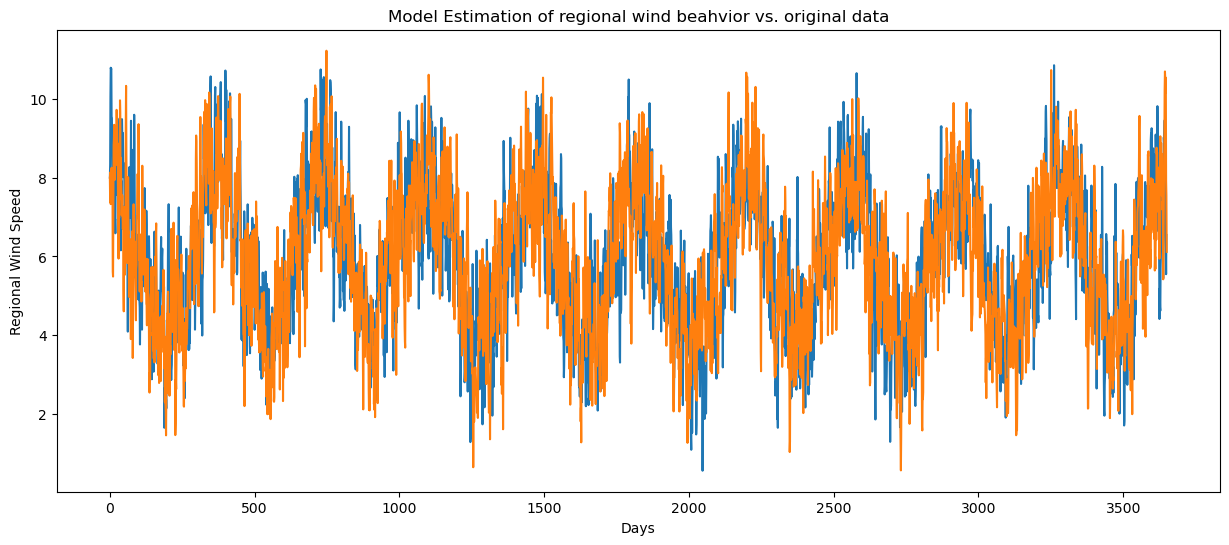

In [655]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['regional wind'])

# graficar modelo predicgo

print(kappa, sigma)
modelo_viento_promedio = simulateTrip_regional(109, sigma,S0=8)
plt.plot(modelo_viento_promedio)
plt.title("Model Estimation of regional wind beahvior vs. original data")
plt.xlabel("Days")
plt.ylabel("Regional Wind Speed")
plt.show()


### Ver que tan real y fidedigno e el paramtro con medidas de error

## Estimar diferencia entre molinos

### Calculamos la diferencia Di+1 - Di

In [656]:
# new column with the diff between one day and the previous one

data["diff_wind_gap"] = data["wind gap norte sur"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_regional,X1,diff_wind_gap
0,1,8.000000,0.000000,0.346296,0.000000,0.181523
1,2,8.346296,0.181523,1.716019,-0.000950,0.007120
2,3,10.062316,0.188643,0.729021,-0.005653,-0.117558
3,4,10.791337,0.071085,-0.037244,-0.007655,0.007358
4,5,10.754093,0.078442,0.017364,-0.007558,0.563745


### Regresion lineal

In [657]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Calcular las diferencias Y_i = D_{i+1} - D_i
data['diff_wind_gap'] = data['wind gap norte sur'].diff().shift(-1)

# Calcular X1_i = (-Di) * Δ 
data['X_wind_gap'] = -1 *data["wind gap norte sur"][1:] * DELTA 

# Calcular W_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de W_i, si no, deberás calcularla
# W_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que W_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_wind_gap = data[['X_wind_gap']][1:-1]
Y_wind_gap = data[['diff_wind_gap']][1:-1]
print("NULOS:  " + str( X_wind_gap.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_wind_gap, Y_wind_gap)


# Obtener el valor de beta (pendiente)
beta = model.coef_[0][0]


print(f"Valor estimado de beta: {beta}")


NULOS:  X_wind_gap    0
dtype: int64
Valor estimado de beta: 48.37684937653269


### Calculamos gamma

In [658]:
# Calcular los residuos de la regresión

Y_wind_gap_np = np.array(Y_wind_gap)
predicted_wind_gap_np = np.array(model.predict(X_wind_gap))

# Calcular el error
error_WG = Y_wind_gap_np - predicted_wind_gap_np
var_WG = error_WG.var()
gamma = np.sqrt(var_WG / DELTA)

print(f"Valor estimado de gamma: {gamma}")


Valor estimado de gamma: 10.091946894398104


### Graficos: Simulacion de diferencia de viente entre ambos molinos

In [659]:
beta, gamma

(48.37684937653269, 10.091946894398104)

48.37684937653269 10.091946894398104


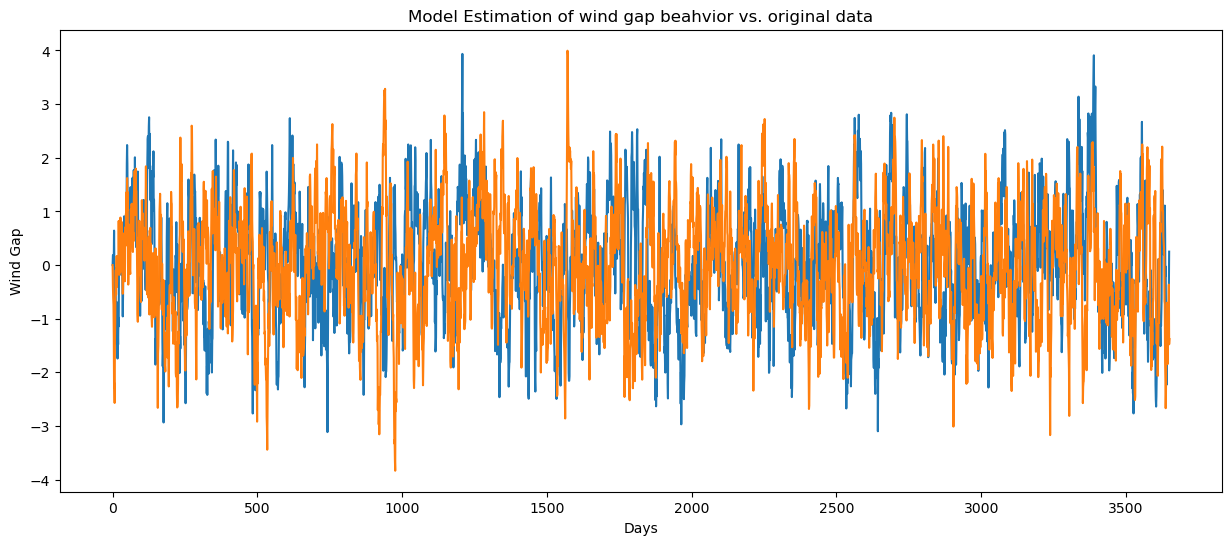

In [660]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['wind gap norte sur'])


# graficar modelo predicgo
print(beta, gamma)
wind_gap_trip = simulateTrip_windgap(beta, gamma)

plt.plot(wind_gap_trip)
plt.title("Model Estimation of wind gap beahvior vs. original data")
plt.xlabel("Days")
plt.ylabel("Wind Gap")

plt.show()

### Ver que tan real y fidedigno e el paramtro con medidas de error

# 2

## Simulacion simultanea de molinos (norte y sur) con M caminos

In [661]:
def simulacion(kappa, sigma,beta,gamma, dias = N, M = 100,seed = 42):
# m = cantidad de caminos
# simula n dias de los m molinos 
    np.random.seed(seed)
    molinoNorte, molinoSur, diff = np.zeros((M, dias)), np.zeros((M, dias)), np.zeros((M, dias))
    Z,W = np.random.normal(0, 1, (M, dias)), np.random.normal(0, 1, (M, dias))
    
    molinoNorte[:,0] = S0
    diff[:,0] = D0

    for t in range(1, dias):
        molinoNorte[:,t] = molinoNorte[:, t-1] + kappa * (theta(np.zeros(M) + t) - molinoNorte[:, t-1]) * DELTA + np.sqrt(DELTA) * Z[:,t] * sigma
        diff[:,t] = diff[:, t-1] - beta * diff[:, t-1] * DELTA + np.sqrt(DELTA) * W[:,t] * gamma
        molinoSur[:,t] = molinoNorte[:,t] + diff[:,t]
    return molinoNorte , molinoSur   

In [662]:
M = 50
simulations = simulacion(kappa, sigma,beta,gamma,dias= N, M=M)

### Grafico

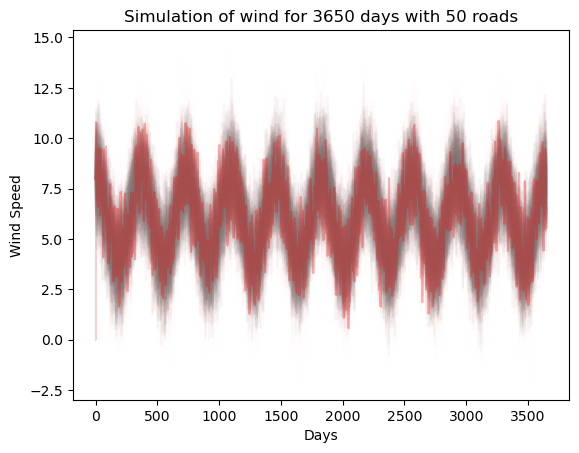

In [663]:
# Plot simulation
for i in range(M):
    # color gray and alpha 0.1
    plt.plot(simulations[0][i,:], color='gray', alpha=0.05)
    plt.plot(simulations[1][i,:], color='red', alpha=0.005)

plt.plot(data['regional wind'],color="red", alpha=0.3)
plt.title(f"Simulation of wind for {N} days with {M} roads")
plt.xlabel("Days")
plt.ylabel("Wind Speed")
plt.show()

### Promedio de todos los cmainos para verificar que se acerca a la data historica + error o varianza de este promedio como medidas de seguirdad

RMSE for Simulated Average Wind: 1.18


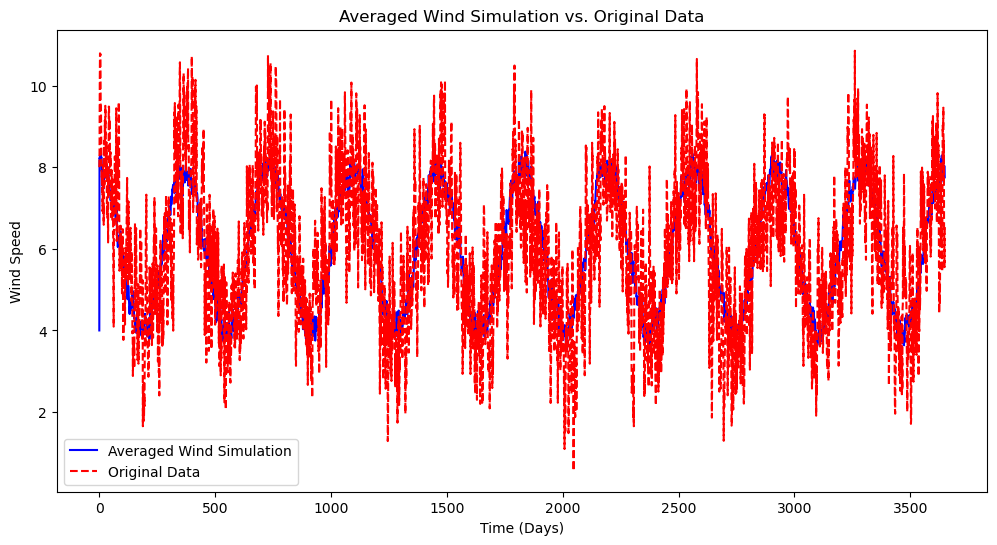

In [664]:
## corregir

# Average the simulations
avg_molinoNorte = np.mean(simulations[0], axis=0)
avg_molinoSur = np.mean(simulations[1], axis=0)

# Average wind speed (combine average Norte and Sur)
average_wind_simulation = (avg_molinoNorte + avg_molinoSur) / 2

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data['regional wind'], average_wind_simulation))

print(f"RMSE for Simulated Average Wind: {rmse:.2f}")

# Plot the averaged simulation
plt.figure(figsize=(12, 6))

plt.plot(average_wind_simulation, label='Averaged Wind Simulation', color='blue')
plt.plot(data['regional wind'], label='Original Data', color='red', linestyle='--')
plt.title('Averaged Wind Simulation vs. Original Data')
plt.xlabel('Time (Days)')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

## Ganancia con la expecion de roturas y prendido y apagado del molino consideradas

### Constantes

In [665]:
# el ingreso diario generado es 1000 ∗ Si dolares si el molino esta prendido ese dia
PRICE = 1000
# La probabilidad de que el molino se rompa en el dia i, si estaba activo en el dia i −1, es 0.25 ∗ S(i)2∆.
BREAK_PROB = 0.25
# Si el molino falla un dıa, ese dia no estara activo y se arreglara el mismo dıa a un costo de 200 mil dolares
BREAK_COST = 200000
# El acto de apagar el molino cuesta 1000 dolares cada vez. Prenderlo no cuesta nada.
TURN_OFF_COST = 1000
TURN_ON_COST = 0
# La tasa de inter ́es es del 5% anual con capitalizacion diaria (el cashflow en dia i se descuenta como e−0.05i/365)
INTEREST_RATE = 0.05



### Funciones Utiles

In [666]:

def proba_romperse(S):
    return BREAK_PROB * np.array(S) ** 2 * DELTA

def inversa_proba_romperse(p):
    return np.sqrt( p / (BREAK_PROB*DELTA))

def ingreso(S:List[float], isOn:List[bool],seRompio:List[bool]):
    break_cost = BREAK_COST * np.logical_and(isOn,seRompio)
    return PRICE * np.array(S) * np.logical_and(isOn,np.logical_not(np.array(seRompio)))  - break_cost


def nextStateIsOn(S:List[float], isOn:List[bool],k): #     TT , TF , FT , FF
    turn_off_candidate = np.array(S) >= k
    prender = ~np.logical_and(isOn , turn_off_candidate)# TT = 0, TF = 0, FT = 0, FF = 1
    apagar = np.logical_and(isOn , turn_off_candidate)  # TT = 1, TF = 0, FT = 0, FF = 0

    costo_prender_total = prender * TURN_ON_COST
    costo_apagar_total = apagar * TURN_OFF_COST

    nextIsOn = ~turn_off_candidate
    
    return nextIsOn, costo_prender_total + costo_apagar_total

def seRompio(S:List[float],isOn:List[bool]):
    return np.logical_and(np.random.uniform(0,1,size=(np.array(S).shape)) < proba_romperse(S),isOn)



### Probabilidad de romperse

Total area under the curve where breakage probability is less than 0.5: 4.49


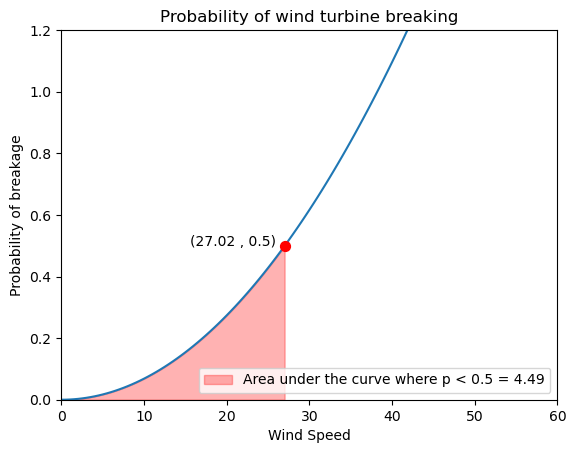

In [667]:
S = np.arange(0,60,0.5)
p = proba_romperse(S)

threshold_prob = 0.5
viento_threshold = inversa_proba_romperse(threshold_prob)
plt.plot(S,p)
plt.title("Probability of wind turbine breaking")
plt.xlabel("Wind Speed")
plt.ylabel("Probability of breakage")

# Calculate the area under the curve where the breakage probability exceeds the threshold
mask = p <= threshold_prob


# Calculate the area under the curve where the breakage probability exceeds the threshold

area_under_curve = simpson(y=p[mask], x=S[mask])

print(f"Total area under the curve where breakage probability is less than {threshold_prob}: {area_under_curve:.2f}")


# Add more space between the point and the text (adjusting the position slightly)
#plt.text(39.85, 0.989, f'(38.21 , 1.00)', fontsize=10, ha='left')

#plt.axhline(threshold_prob, color='red', linestyle='--', label=f"Threshold Probability = {0.5}")

# Mark the specific point

plt.scatter(viento_threshold, threshold_prob, color='red', s=50, zorder=5)
plt.text(viento_threshold - 1, threshold_prob, f'({round(viento_threshold,2)} , {threshold_prob})', fontsize=10, ha='right')
#plt.axvline(27.03, color='green', linestyle='--', label=f"Break Point ≈ {27.03:.2f} m/s")

# Shade the area under the curve where probability exceeds the threshold
plt.fill_between(S, 0, p, where=(p <= threshold_prob), color='red', alpha=0.3, label = f"Area under the curve where p < {threshold_prob} = {area_under_curve:.2f}")
plt.legend()
plt.ylim(0,1.2)
plt.xlim(0,60)
plt.show()

# 8. Si considero al ingreso total durante el mes de agosto (sin descontar) como una
variable aleatoria, cu ́al es su distribuci ́on bajo el umbral de operaci ́on  ́optimo?

In [677]:
def ganancia(molinoNorte, molinoSur,k,seed=0):
    """M simulaciones de molino norte y M simulaciones de molino sur y n dias para cada simulacion, k el umbral elegido 
    
    """
    if seed != 0:
        np.random.seed(seed)
    #si el molino esta prendido en el dia i
    isOnNorte = np.zeros_like(molinoNorte) + 1
    isOnSur = np.zeros_like(molinoNorte) + 1

    #calculamos dia a dia ganancia acumulada
    gananciaNorte = np.zeros_like(molinoNorte)
    gananciaSur = np.zeros_like(molinoSur)

    #si hay una rotura en el dia i, independiente a prendido o apagado
    roturaNorte = np.zeros_like(molinoNorte)
    roturaSur = np.zeros_like(molinoSur)
    
    # recorremos dia a dia 
    for t in range(1,molinoNorte.shape[1]-1):
        #para el norte:
        #chequeamos si ayer estuvo prendido o apagado segun el viento de hoy 
        #me fijo si hoy se rompio (viento de hoy + prendido y apagado)
        #calculamos el ingreso(viento + prendido si esta roto)
        #maximizamos beneficios 
        isOnNorte[:,t],costosNorte_t = nextStateIsOn(molinoNorte[:,t],isOnNorte[:,t-1],k)
        roturaNorte[:,t] = seRompio(molinoNorte[:,t],isOnNorte[:,t])
        ingresoNorte_t = ingreso(molinoNorte[:,t],isOnNorte[:,t],roturaNorte[:,t])
        gananciaNorte[:,t] =  gananciaNorte[:,t-1] + ingresoNorte_t - costosNorte_t

        #para el sur:
        isOnSur[:,t],costosSur_t = nextStateIsOn(molinoSur[:,-1],isOnSur[:,t],k)
        roturaSur[:,t] = seRompio(molinoSur[:,t],isOnSur[:,t])
        ingresoSur_t = ingreso(molinoSur[:,t],isOnSur[:,t],roturaSur[:,t])
        gananciaSur[:,t] = gananciaSur[:,t-1] +  ingresoSur_t - costosSur_t
        
    
    return gananciaNorte, gananciaSur,isOnNorte,isOnSur, roturaNorte, roturaSur

### VAN

In [678]:
#INTEREST_RATE = 0.05  # tasa de interés de ejemplo

def van(ganancia,cumSum:bool=True):
    dia_a_dia = np.diff(ganancia, axis=1)
    # print(dia_a_dia.shape)
    tasaDescuento = [np.exp(-INTEREST_RATE * i / 365) for i in range(dia_a_dia.shape[1])]
    if cumSum:
        return np.cumsum(dia_a_dia * tasaDescuento, axis=1)
    else:
        return dia_a_dia * tasaDescuento

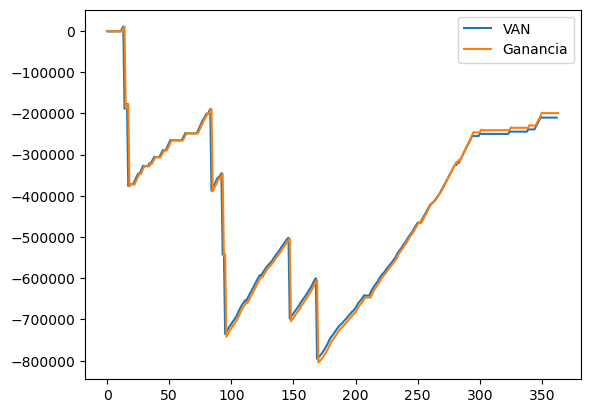

VAN Norte: -4284.3
VAN Sur: 2320.23
VAN total = -1964.08


In [684]:
m = 50
n = 365 
K = 15

simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m)
gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = ganancia(simulations[0],simulations[1],7)


van_norte = van(gananciaNorte)
van_sur = van(gananciaSur)

#plot
plt.plot(van_norte[0][:-1])
plt.plot(gananciaNorte[0][:-1])
plt.legend(["VAN","Ganancia"])
plt.show()



print(f"VAN Norte: {round(van_norte[-1][-1],2)}")
print(f"VAN Sur: {round( van_sur[-1][-1], 2)}")
print(f"VAN total = {round(van_norte[-1][-1] + van_sur[-1][-1], 2)}")


# 3

### Implementa una simulacion para la evolucion simultanea del viento en cada molino, las roturas, las decisiones de apagado y encendido, y la acumulacion de cashflows enel tiempo.

In [685]:
m = 200
n = 365 
K = 15
seed = 10
simulations = simulacion(kappa, sigma,beta,gamma,dias= n, M=m)
# gananciaNorte, gananciaSur, isOnNorte,isOnSur, roturaNorte, roturaSur = ganancia(simulations[0],simulations[1],5)
gananciaNorteI = [[ganancia(simulations[0],simulations[1],k,seed)[0],ganancia(simulations[0],simulations[1],k,seed)[2],ganancia(simulations[0],simulations[1],k,seed)[4]] for k in np.arange(0,K,1)]
print(gananciaNorteI[5][0].shape,gananciaNorteI[5][1].shape,gananciaNorteI[5][2].shape)
gananciaPromedio = np.array([np.mean(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])
gananciaVarianza = np.array([np.var(gananciaNorteI[k][0][:,-2]) for k in range(len(gananciaNorteI))])

color = np.array(gananciaNorteI) 

(200, 365) (200, 365) (200, 365)


### Graficos 

In [687]:

def plot_sine(a,b):
    prndido_y_roto = np.logical_and(gananciaNorteI[a][1][b,:],gananciaNorteI[a][2][b,:])
    # print("Cant rompimientos: ",sum(prndido_y_roto[7]))
    #                           isOn                              seRompio
    color = np.array(1+-(gananciaNorteI[a][1][b,:]) +  gananciaNorteI[a][2][b,:]  + prndido_y_roto) 
    # change value 3 to 1 if isOn
    # color = np.where(color == 3, 1, color)

    plt.figure(figsize=(10,5))
    plt.yticks([])
    plt.scatter(range(simulations[0].shape[1]-2),simulations[0][b,1:-1],c=color[1:-1],cmap='coolwarm_r',alpha=0.5)
    # plot threshold k
    plt.axhline(a, color='orange')
    plt.show()
    plt.figure(figsize=(10,5))
    plt.yticks([])
    for i in range(m):
        # plot text
        if i == b:
            plt.plot(gananciaNorteI[a][0][i,:-1],color='red',alpha=0.5)
        else:
            plt.plot(gananciaNorteI[a][0][i,:-1],color='gray',alpha=0.05)

    # plot ganancia promedio
    plt.axhline(0, color='black')
    plt.plot(np.mean(gananciaNorteI[a][0][:,:-1],axis=0),color='black',alpha=0.9)
    # plt.text(0, 2000.0, "Ganancia del año: " + str(np.mean(gananciaNorteI[a][0][:,-2],axis=0)), fontsize=20)

    plt.show()

    # plot ganancia promedio
    plt.figure(figsize=(10,5))
    # plt.ylim(-150000,1500000)
    plt.plot(np.sum(gananciaPromedio))
    plt.axhline(0, color='black')
    # plot ganancia promedio + desviacion estandar
    plt.plot(gananciaPromedio, color='blue')
    plt.plot(gananciaPromedio + (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.63)
    plt.plot(gananciaPromedio - (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.63)
    plt.plot(gananciaPromedio + (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.33)
    plt.plot(gananciaPromedio - (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='gray',alpha=0.33)

    plt.fill_between(range(K), gananciaPromedio - (gananciaVarianza / len(gananciaVarianza))**0.5, gananciaPromedio + (gananciaVarianza / len(gananciaVarianza))**0.5, color='gray')
    plt.fill_between(range(K), gananciaPromedio - (2*gananciaVarianza / len(gananciaVarianza))**0.5, gananciaPromedio + (2*gananciaVarianza / len(gananciaVarianza))**0.5, color='gray')
    plt.axvline(a, color='red')
    plt.show()

    
# Crear un slider interactivo usando ipywidgets

interact(plot_sine, a=widgets.IntSlider(min=0, max=K-1, step= 1, value=7), b=widgets.IntSlider(min=0, max=m-1, step= 1, value=0))


interactive(children=(IntSlider(value=7, description='a', max=14), IntSlider(value=0, description='b', max=199…

<function __main__.plot_sine(a, b)>

# 4. junto con un camino t ́ıpico del viento simulado grafic ́a la evoluci ́on contempor ́anea
del estado de cada molino (momentos en que est ́a activo / inactivo, momentos en los
que se rompi ́o, etc). Tiene sentido lo que ves?

# 5. A partir de un n ́umero suficientemente grande de caminos calcula el VAN esperado
de tus molinos como funci ́on del umbral de apagado y encendido. Acompa ̃na este y
otros estimadores con medidas de error est ́andar

# 6. Cu ́al es el valor  ́optimo para el umbral de apagado y encendido, o sea, que maximiza el valor actual neto de cashflows generados durante un a ̃no?


# 7. Cu ́anto es la ganancia de VAN en este caso vs la operaci ́on ingenua que nunca
apaga los molinos?

# 8. Si considero al ingreso total durante el mes de agosto (sin descontar) como una
variable aleatoria, cu ́al es su distribuci ́on bajo el umbral de operaci ́on  ́optimo?

# 9. Cu ́al es el n ́umero medio de roturas por a ̃no que sufre el molino bajo la estrategia
 ́optima y cu ́antas si no se lo apaga nunca?

# 10. Bajo la estrategia  ́optima, cu ́al es el n ́umero de d ́ıas por a ̃no en los que cada
molino est ́a inactivo en promedio, ya sea por apagado voluntario o rotura?

# 11. Cu ́al es la probabilidad de que los dos molinos est ́en inactivos el 9 de julio? Y
en alg ́un d ́ıa del a ̃no?

# 12. Cu ́al es la correlaci ́on entre los ingresos totales mensuales de mayo de los dos
molinos?

# 13. Cu ́an sensible es el VAN de mi negocio al costo del arreglo de roturas? Si el costo
del arreglo es 250 mil d ́olares, cambia el umbral  ́optimo?

# 14. Cu ́an sensible es el VAN de mi negocio a la media estacional del viento?